# Introdução

Este estudo tem como instuito analisar e realizar predições sobre a COVID-19, tendo como protagonista principal o Brasil e como ele se compara a outros países do mundo.

Este case foi proposto pela empresa `Digio`, como teste técnico para o ingresso no time de Data Science e tem como objetivo macro abordar os seguintes pontos:

1.   **Levante informações e gere visualizações que julgue relevantes sobre a Pandemia de COVID-19 no Brasil.**

2.   **Qual ou quais seriam indicadores adequados ao fazer a comparação entre diferentes países? Por quê? Faça
pelo menos um gráfico com o(s) indicador(es) escolhido(s).**

3.   **É possível prever a quantidade de casos que teríamos no Brasil sem as medidas de isolamento social
adotadas? Como?**

4.   **Baseado no cenário atual que temos no país, faça uma previsão da evolução da pandemia nos próximos 30
dias. E para os próximos 6 meses? O que você pode dizer sobre a acurácia dessas previsões?**



---



# Fonte de dados

Os dados indicados pela empresa e estão alocados no repositório da `data.world`, no link a seguir:

 https://data.world/covid-19-data-resource-hub/covid-19-case-counts

 ---



 ### Este estudo foi realizado por `Ricardo Rossi Tegão`, entre os dias 23/10 e 28/10



# Importando bibliotecas

In [ ]:
# IPI request library
import requests

import numpy as np
import pandas as pd
import json

#Interactive plot library
import plotly.graph_objects as go 
import plotly.express as px

from scipy import integrate, interpolate, optimize
from scipy.integrate import odeint

import warnings
warnings.filterwarnings('ignore')

# Conectando com os dados da plataforma `data.world`

Os dados serão consumidos pela API fornecida pela própria plataforma, que está muito bem documentada no link a seguir. 
https://apidocs.data.world/toolkit/api/api-endpoints/queries/sqlpost


Tal API permite que os dados sejam consumidos através do metódo POST, de forma que se faz necessário fornecer 2 parâmetros de requição, que vão diretamente no ENDPOINT (URL):

*   **owner** : User name 
*   **id** : Dataset unique identifier

A chave de autorização que deve ser passada como `Header`:

*   **Authorization** : oauth_access_token

E por ultimo a consulta em SQL que se deseja realizar, que deve estar contida `Body` da requisição:

*   **query** : Database consult

---
Os parametros e a chave de autorização foram carregados em um arquivo `.json` construido por mim, de forma que não fosse necessário compartilhar minha chave da API. Deixo abaixo formato que este arquivo se encontra.


```
{

    "owner" : "YOUR_USERNAME_HERE",
    "id" : "YOUR_DATASET_HERE",
    "Authorization" : "YOUR_AUTHORIZATION_KEY_HERE"

}

```





Para realizar a implementação desta requisição HTTP, foi utilizada a biblioteca `requests`






## Lendo as credenciais

In [ ]:
def readCredentials(file_path:str) -> dict:
  credentials_file = open(file_path)
  credentials = json.load(credentials_file)
  return credentials

In [ ]:
credentials = readCredentials('/content/credentials.json')

## Realizando a chamada da API

A chamada da API que trará os dados em questão, será feita atraves da função `apiCall`. O retorno da API em questão é um `.json` que é imterpretado no python como um dicionári.

A função em questão recebe a resposta da API e ja faz a transformação dos dados para um `Pandas DataFrame`, que é retornado para o usuário.

Para a utilização da função, basta enviar os dados presentes no arquivo `credentials.json` (em formato de dicionário) e a `query` que deseja realizar.


In [ ]:
def apiCall(owner:str, id:str, Authorization:str, query:str) -> pd.DataFrame:

  API_ENDPOINT = f"https://api.data.world/v0/sql/{owner}/{id}"
  data = {'query':query, 
        "includeTableSchema":False}
  header = {'Authorization':Authorization}
  response = requests.post(url = API_ENDPOINT, data = data, headers = header)
  return  pd.DataFrame(response.json())

In [ ]:
query = """ select * from covid_19_activity """
df_activity = apiCall(**credentials, query = query)
df_activity.head()

,people_positive_cases_count,county_name,province_state_name,report_date,continent_name,data_source_name,people_death_new_count,county_fips_number,country_alpha_3_code,country_short_name,country_alpha_2_code,people_positive_new_cases_count,people_death_count
0,1365.0,None,Manitoba,2020-09-09,America,Public Health Agency of Canada,0,NaN,CAN,Canada,CA,16,16.0
1,36.0,None,Prince Edward Island,2020-07-23,America,Public Health Agency of Canada,0,NaN,CAN,Canada,CA,0,0.0
2,4.0,None,Manitoba,2020-03-15,America,Public Health Agency of Canada,0,NaN,CAN,Canada,CA,3,0.0
3,14856.0,None,Ontario,2020-04-27,America,Public Health Agency of Canada,57,NaN,CAN,Canada,CA,424,892.0
4,55.0,None,Prince Edward Island,2020-09-12,America,Public Health Agency of Canada,0,NaN,CAN,Canada,CA,0,0.0


In [ ]:
query = """ select * from covid_19_cases """
df_cases = apiCall(**credentials, query = query)
df_cases.head()

,case_type,people_total_tested_count,cases,difference,date,combined_key,country_region,province_state,admin2,iso2,iso3,fips,lat,long,population_count,people_hospitalized_cumulative_count,data_source,prep_flow_runtime
0,Confirmed,NaN,6,0,2020-05-22,Western Sahara,Western Sahara,N/A,None,EH,ESH,None,24.215500,-12.885800,597330.0,NaN,2019 Novel Coronavirus COVID-19 (2019-nCoV) Da...,2020-06-04T23:15:39
1,Confirmed,NaN,0,0,2020-02-03,Switzerland,Switzerland,N/A,None,CH,CHE,None,46.818200,8.227500,8654618.0,NaN,2019 Novel Coronavirus COVID-19 (2019-nCoV) Da...,2020-06-04T23:15:39
2,Deaths,NaN,0,0,2020-03-01,Cyprus,Cyprus,N/A,None,CY,CYP,None,35.126400,33.429900,1207361.0,NaN,2019 Novel Coronavirus COVID-19 (2019-nCoV) Da...,2020-06-04T23:15:39
3,Confirmed,NaN,23,0,2020-04-21,Antigua and Barbuda,Antigua and Barbuda,N/A,None,AG,ATG,None,17.060800,-61.796400,97928.0,NaN,2019 Novel Coronavirus COVID-19 (2019-nCoV) Da...,2020-06-04T23:15:39
4,Deaths,NaN,56,0,2020-05-11,Thailand,Thailand,N/A,None,TH,THA,None,15.870032,100.992541,69799978.0,NaN,2019 Novel Coronavirus COVID-19 (2019-nCoV) Da...,2020-06-04T23:15:39


## Dados Disponíveis

O repositório de dados em questão possui duas tabelas como fontes de dados:



*   **covid_19_activity**
*   **covid_19_cases**

A tabela **covid_19_cases** foi descontinuada e não recebe atualizações desde o dia 5 de Junho, logo, foi substituída pela **covid_19_activity**. Entretanto, existem algumas informações valiosas existentes na tabela que foi descontinuada, como:


-   Latitude (lat)
-   Longitude (long)
-   População do País (population_count)

Tais informações serão incorporadas a tabela **covid_19_activity**, afim de não ocasionar a perda de informação apenas por uma descontinualidade da tabela.

---

Para agregar as informações citadas acima, é necessário realizar alguns tratamentos e partir de algumas premissas, principalmente para a tabela **covid_19_cases**.

A tabela **covid_19_cases** está normalizada pelo campo `province_state`, porém, este camo só é preenchido para os países Australia, Canada, China, Denmark, France, Netherlands, United Kingdom, United States. Como as chaves de cruzamentos entre as tabelas é dada pelos campos `iso2` ou `iso3` (para a tabela **covid_19_cases**) e `country_alpha_2_code` ou `country_alpha_3_code` (para a tabela **covid_19_activity**).
Desta forma, foi necessário normalizar através da premissa de que a latitude e longitude que representa o país será data pela provincia onde ocorreu a maior incidencia de testes positivos em um único dia ( `MAX(difference)` )

Desta forma, foi possível garantir que carda `iso2` e `iso3` tivesse apenas uma `lat` e `long`, **evitando assim o produto cartesiano quando o cruzamento entre as bases fosse realizado.**


In [ ]:
query = """ with cte_cases as (select iso2,iso3,max(difference) as difference,max(population_count) as population_count from covid_19_cases group by iso2,iso3),
final_cases as (
select distinct 
    covid_19_cases.iso2,
    covid_19_cases.iso3,
    covid_19_cases.lat,
    covid_19_cases.long,
    cte_cases.population_count
from covid_19_cases 
inner join cte_cases ON
    covid_19_cases.iso2 = cte_cases.iso2
    and covid_19_cases.iso3 = cte_cases.iso3
    and covid_19_cases.difference = cte_cases.difference)
select activity.*, 
    final_cases.lat,
    final_cases.long,
    final_cases.population_count
from covid_19_activity as activity
left join final_cases ON
    activity.country_alpha_3_code = final_cases.iso3
    and activity.country_alpha_2_code = final_cases.iso2;"""

df = apiCall(**credentials, query = query)
df.head()

,people_positive_cases_count,county_name,province_state_name,report_date,continent_name,data_source_name,people_death_new_count,county_fips_number,country_alpha_3_code,country_short_name,country_alpha_2_code,people_positive_new_cases_count,people_death_count,lat,long,population_count
0,1365.0,None,Manitoba,2020-09-09,America,Public Health Agency of Canada,0,NaN,CAN,Canada,CA,16,16.0,52.9399,-73.5491,14711827.0
1,36.0,None,Prince Edward Island,2020-07-23,America,Public Health Agency of Canada,0,NaN,CAN,Canada,CA,0,0.0,52.9399,-73.5491,14711827.0
2,4.0,None,Manitoba,2020-03-15,America,Public Health Agency of Canada,0,NaN,CAN,Canada,CA,3,0.0,52.9399,-73.5491,14711827.0
3,14856.0,None,Ontario,2020-04-27,America,Public Health Agency of Canada,57,NaN,CAN,Canada,CA,424,892.0,52.9399,-73.5491,14711827.0
4,55.0,None,Prince Edward Island,2020-09-12,America,Public Health Agency of Canada,0,NaN,CAN,Canada,CA,0,0.0,52.9399,-73.5491,14711827.0


# Análise Prescritiva

Os dois primeiros objetivos macros que foram salientados logo na introdução eram:

1.   **Levante informações e gere visualizações que julgue relevantes sobre a Pandemia de COVID-19 no Brasil.**

2.   **Qual ou quais seriam indicadores adequados ao fazer a comparação entre diferentes países? Por quê? Faça
pelo menos um gráfico com o(s) indicador(es) escolhido(s).**

Estes dois objetivos podem ser alcançados a partir de uma análise prescritiva, onde será possível traduzir o cenário atual a partir dos dados disponíveis e desta forma

## Visualização dos Dados

### Quantidade de Casos

#### Quantidade absoluta de casos por país

In [ ]:
df_aux = df.groupby(['lat','long','country_short_name','continent_name','country_alpha_3_code']).sum().reset_index()[['lat','long','people_positive_new_cases_count','country_short_name','continent_name','country_alpha_3_code']]

fig = px.scatter_geo(df_aux, locations="country_alpha_3_code", color="continent_name",
                     hover_name="country_short_name", size="people_positive_new_cases_count",
                     projection="natural earth")

fig.update_layout(
        title_text = 'QTD1) Quantidade absoluta de casos por país')


fig.show()


#### Evolução da quantidade de casos ao longo de 2020

In [ ]:
df_aux = df[['lat','long','people_positive_new_cases_count','country_short_name','continent_name','country_alpha_3_code','report_date']]
df_aux['month'] = pd.to_datetime(df_aux['report_date']).dt.month
df_aux['year'] = pd.to_datetime(df_aux['report_date']).dt.year

df_aux = df_aux.groupby(['lat','long','country_short_name','continent_name','country_alpha_3_code','month','year']).sum().groupby(level=0).cumsum().reset_index()


fig = px.scatter_geo(df_aux[df_aux['year']== 2020], locations="country_alpha_3_code", color="continent_name",
                     hover_name="country_short_name", size="people_positive_new_cases_count",animation_frame="month",
                     projection="natural earth")

fig.update_layout(
        title_text = 'QTD2) Evolução da quantidade de casos ao longo de 2020')


fig.show()

In [ ]:
fig = go.Figure()
for country in df_aux['country_alpha_3_code'].unique():
  fig.add_trace(go.Scatter(x=list(df_aux[(df_aux['year']== 2020) & (df_aux['country_alpha_3_code'] == country)]['month']), 
                           y=list(df_aux[(df_aux['year']== 2020) & (df_aux['country_alpha_3_code'] == country)]['people_positive_new_cases_count']),
                           mode='lines',
                           name= country))

fig.update_layout(
        title = 'QTD3) Evolução da quantidade de casos ao longo de 2020',
        xaxis_title = 'Month',
        yaxis_title = 'Qtd. Casos')
fig.show()

#### Visão Brasil

In [ ]:
df_aux = df[['lat','long','people_positive_new_cases_count','country_short_name','continent_name','country_alpha_3_code','report_date']]
df_aux['month'] = pd.to_datetime(df_aux['report_date']).dt.month
df_aux['year'] = pd.to_datetime(df_aux['report_date']).dt.year

# Visão acumulada
df_acumulado = df_aux.groupby(['lat','long','country_short_name','continent_name','country_alpha_3_code','month','year','report_date']).sum().groupby(level=0).cumsum().reset_index()

#visão geral
df_geral = df_aux.groupby(['lat','long','country_short_name','continent_name','country_alpha_3_code','month','year','report_date']).sum().reset_index()

##### Visão diária e mensal

In [ ]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x= df_acumulado[(df_acumulado['year']== 2020) & (df_acumulado['country_alpha_3_code'] == 'BRA')]['report_date'],
        y= df_acumulado[(df_acumulado['year']== 2020) & (df_acumulado['country_alpha_3_code'] == 'BRA')]['people_positive_new_cases_count'],
        mode='lines',
        name = 'Acumulado'
    ))

fig.add_trace(
    go.Bar(
        x= df_geral[(df_geral['year']== 2020) & (df_geral['country_alpha_3_code'] == 'BRA')]['report_date'],
        y= df_geral[(df_geral['year']== 2020) & (df_geral['country_alpha_3_code'] == 'BRA')]['people_positive_new_cases_count'],
        name = 'Diário' 
    ))

fig.update_layout(
        title = 'QTD4) Evolução da quantidade de casos ao longo de 2020',
        xaxis_title = 'Dias',
        yaxis_title = 'Qtd. Casos')

fig.show()

In [ ]:
# Visão acumulada
df_acumulado = df_aux.groupby(['lat','long','country_short_name','continent_name','country_alpha_3_code','month','year']).sum().groupby(level=0).cumsum().reset_index()

#visão geral
df_geral = df_aux.groupby(['lat','long','country_short_name','continent_name','country_alpha_3_code','month','year']).sum().reset_index()


fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x= df_acumulado[(df_acumulado['year']== 2020) & (df_acumulado['country_alpha_3_code'] == 'BRA')]['month'],
        y= df_acumulado[(df_acumulado['year']== 2020) & (df_acumulado['country_alpha_3_code'] == 'BRA')]['people_positive_new_cases_count'],
        mode='lines+markers',
        name = 'Acumulado'
    ))

total = df_acumulado[(df_acumulado['year']== 2020) & (df_acumulado['country_alpha_3_code'] == 'BRA')]['people_positive_new_cases_count'].max()

fig.add_trace(
    go.Bar(
        x= df_geral[(df_geral['year']== 2020) & (df_geral['country_alpha_3_code'] == 'BRA')]['month'],
        y= df_geral[(df_geral['year']== 2020) & (df_geral['country_alpha_3_code'] == 'BRA')]['people_positive_new_cases_count'],
        name = 'Mensal',
        text =  [str(i)+'%' for i in list(round(100*(df_geral[(df_geral['year']== 2020) & (df_geral['country_alpha_3_code'] == 'BRA')]['people_positive_new_cases_count']/total),2))],
        textposition='auto'
    ))


fig.update_layout(
        title = 'QTD5) Evolução da quantidade de casos ao longo de 2020',
        xaxis_title = 'Mes',
        yaxis_title = 'Qtd. Casos')

fig.show()

#### Comparação entre países 

In [ ]:
df_aux = df[['people_positive_new_cases_count','country_short_name']]
df_aux = df_aux.groupby(['country_short_name']).sum().reset_index()
total  = df_aux['people_positive_new_cases_count'].sum()
df_aux = df_aux.sort_values(by = 'people_positive_new_cases_count',ascending= False).head(10).sort_values(by = 'people_positive_new_cases_count',ascending= True)
df_aux['%qtd'] = df_aux['people_positive_new_cases_count']/total




fig = go.Figure(go.Bar(
            x=df_aux['people_positive_new_cases_count'],
            y=df_aux['country_short_name'],
            orientation='h',
            text=   [str(round(100*i,2))+'%' for i in df_aux['%qtd']],
            textposition='auto' ))

fig.update_layout(
    title = ' QTD6) Percentual e Quantidade de Casos para os TOP 10 Países',
    xaxis_title = 'Quantidade',
    yaxis_title = 'Países'
)

fig.show()

### Quantidade de Óbitos

In [ ]:
df_aux = df.groupby(['lat','long','country_short_name','continent_name','country_alpha_3_code']).sum().reset_index()[['lat','long','people_death_new_count','country_short_name','continent_name','country_alpha_3_code']]

fig = px.scatter_geo(df_aux, locations="country_alpha_3_code", color="continent_name",
                     hover_name="country_short_name", size="people_death_new_count",
                     projection="natural earth")

fig.update_layout(
        title_text = 'OBT 1) Quantidade absoluta de óbitos por país')


fig.show()

#### Evolução da quantidade de óbitos ao longo de 2020

In [ ]:
df_aux = df[['lat','long','people_death_new_count','country_short_name','continent_name','country_alpha_3_code','report_date']]
df_aux['month'] = pd.to_datetime(df_aux['report_date']).dt.month
df_aux['year'] = pd.to_datetime(df_aux['report_date']).dt.year

df_aux = df_aux.groupby(['lat','long','country_short_name','continent_name','country_alpha_3_code','month','year']).sum().groupby(level=0).cumsum().reset_index()


fig = px.scatter_geo(df_aux[df_aux['year']== 2020], locations="country_alpha_3_code", color="continent_name",
                     hover_name="country_short_name", size="people_death_new_count",animation_frame="month",
                     projection="natural earth")

fig.update_layout(
        title_text = 'OBT2) Evolução da quantidade de óbitos ao longo de 2020')


fig.show()

In [ ]:
fig = go.Figure()
for country in df_aux['country_alpha_3_code'].unique():
  fig.add_trace(go.Scatter(x=list(df_aux[(df_aux['year']== 2020) & (df_aux['country_alpha_3_code'] == country)]['month']), 
                           y=list(df_aux[(df_aux['year']== 2020) & (df_aux['country_alpha_3_code'] == country)]['people_death_new_count']),
                           mode='lines',
                           name= country))

fig.update_layout(
        title = 'OBT3) Evolução da quantidade de óbitos ao longo de 2020',
        xaxis_title = 'Month',
        yaxis_title = 'Qtd. Óbitos')
fig.show()

#### Visão Brasil

In [ ]:
df_aux = df[['lat','long','people_death_new_count','country_short_name','continent_name','country_alpha_3_code','report_date']]
df_aux['month'] = pd.to_datetime(df_aux['report_date']).dt.month
df_aux['year'] = pd.to_datetime(df_aux['report_date']).dt.year

# Visão acumulada
df_acumulado = df_aux.groupby(['lat','long','country_short_name','continent_name','country_alpha_3_code','month','year','report_date']).sum().groupby(level=0).cumsum().reset_index()

#visão geral
df_geral = df_aux.groupby(['lat','long','country_short_name','continent_name','country_alpha_3_code','month','year','report_date']).sum().reset_index()

##### Visão diária e mensal

In [ ]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x= df_acumulado[(df_acumulado['year']== 2020) & (df_acumulado['country_alpha_3_code'] == 'BRA')]['report_date'],
        y= df_acumulado[(df_acumulado['year']== 2020) & (df_acumulado['country_alpha_3_code'] == 'BRA')]['people_death_new_count'],
        mode='lines',
        name = 'Acumulado'
    ))

fig.add_trace(
    go.Bar(
        x= df_geral[(df_geral['year']== 2020) & (df_geral['country_alpha_3_code'] == 'BRA')]['report_date'],
        y= df_geral[(df_geral['year']== 2020) & (df_geral['country_alpha_3_code'] == 'BRA')]['people_death_new_count'],
        name = 'Diário' 
    ))

fig.update_layout(
        title = 'OBT4) Evolução da quantidade de Óbitos ao longo de 2020',
        xaxis_title = 'Dias',
        yaxis_title = 'Qtd. Óbitos')

fig.show()

In [ ]:
# Visão acumulada
df_acumulado = df_aux.groupby(['lat','long','country_short_name','continent_name','country_alpha_3_code','month','year']).sum().groupby(level=0).cumsum().reset_index()

#visão geral
df_geral = df_aux.groupby(['lat','long','country_short_name','continent_name','country_alpha_3_code','month','year']).sum().reset_index()


fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x= df_acumulado[(df_acumulado['year']== 2020) & (df_acumulado['country_alpha_3_code'] == 'BRA')]['month'],
        y= df_acumulado[(df_acumulado['year']== 2020) & (df_acumulado['country_alpha_3_code'] == 'BRA')]['people_death_new_count'],
        mode='lines+markers',
        name = 'Acumulado'
    ))

total = df_acumulado[(df_acumulado['year']== 2020) & (df_acumulado['country_alpha_3_code'] == 'BRA')]['people_death_new_count'].max()

fig.add_trace(
    go.Bar(
        x= df_geral[(df_geral['year']== 2020) & (df_geral['country_alpha_3_code'] == 'BRA')]['month'],
        y= df_geral[(df_geral['year']== 2020) & (df_geral['country_alpha_3_code'] == 'BRA')]['people_death_new_count'],
        name = 'Mensal',
        text =  [str(i)+'%' for i in list(round(100*(df_geral[(df_geral['year']== 2020) & (df_geral['country_alpha_3_code'] == 'BRA')]['people_death_new_count']/total),2))],
        textposition='auto'
    ))


fig.update_layout(
        title = 'OBT5) Evolução da quantidade de óbitos ao longo de 2020',
        xaxis_title = 'Mes',
        yaxis_title = 'Qtd. Óbitos')

fig.show()

#### Comparação entre países 

In [ ]:
df_aux = df[['people_death_new_count','country_short_name']]
df_aux = df_aux.groupby(['country_short_name']).sum().reset_index()
total  = df_aux['people_death_new_count'].sum()
df_aux = df_aux.sort_values(by = 'people_death_new_count',ascending= False).head(10).sort_values(by = 'people_death_new_count',ascending= True)
df_aux['%qtd'] = df_aux['people_death_new_count']/total




fig = go.Figure(go.Bar(
            x=df_aux['people_death_new_count'],
            y=df_aux['country_short_name'],
            orientation='h',
            text=   [str(round(100*i,2))+'%' for i in df_aux['%qtd']],
            textposition='auto' ))

fig.update_layout(
    title = ' OBT6) Percentual e Quantidade de Óbitos para os TOP 10 Países',
    xaxis_title = 'Quantidade',
    yaxis_title = 'Países'
)

fig.show()

## Resumo da Análise

A análise foi separada em quatro partes:

1.   Quantidade de Casos (gráficos -> QTD1, QTD2, QTD3)
2.   Quantidade de Casos, visão Brasil (gráficos -> QTD4, QTD5)
3.   Comparação entre países, visão quantidade de casos(gráfico -> QTD6)
---
4.   Quantidade de Óbitos (gráficos -> OBT1, OBT2, OBT3)
5.   Quantidade de Óbitos, visão Brasil (gráficos -> OBT4, OBT5)
6.   Comparação entre países, visão quantidade de óbitos (gráfico -> OBT6)

Logo, os gráficos QTD4, QTD5, OBT4, OBT5 atendem o primeiro macro objetivo ("**Levante informações e gere visualizações que julgue relevantes sobre a Pandemia de COVID-19 no Brasil.**"). Passando diferentes perspectivas da quantidade de casos e óbitos, de maneira absoluta e ao longo do tempo.

O segundo macro objetivo (**"Qual ou quais seriam indicadores adequados ao fazer a comparação entre diferentes países? Por quê? Faça
pelo menos um gráfico com o(s) indicador(es) escolhido(s)."**) foi atendido pelos gráficos  QTD1, QTD2, QTD3, QTD6, OBT1, OBT2, OBT3 e OBT6, que servem como indicadores para a quantidade de casos e óbitos, de maneira estática e ao longo do tempo.

Falando um pouco mais sobre os indicadores (solicitados no segundo macro objetivo), é possível separa-los da seguinte forma:

- Comparação entre a quantidade absoluta de casos -> QTD1
- Comparação entre a contribuição percentual e absoluta na quantidade  de casos -> QTD6
- Comparação entre a quantidade de casos, ao longo do tempo -> QTD2, QTD3
---
- Comparação entre a quantidade absoluta de óbitos -> OBT1
- Comparação entre a contribuição percentual e absoluta na quantidade  de óbitos -> OBT6
- Comparação entre a quantidade de óbitos, ao longo do tempo -> OBT2, OBT3




# Medidas de Isolamento

O terceiro macro objetivo, se baseia em responder a seguinte pergunta:

**"É possível prever a quantidade de casos que teríamos no Brasil sem as medidas de isolamento social
adotadas? Como?"**

A resposta dessa pergunta depende muito da base de dados que será utilizada. A base de dados utilizada neste trabalho não possui nenhuma marcação de quando e por quanto tempo uma determinada medida de isolamento social foi implementada. Desta forma, fica impossível isolar os dados que estão ou não sobre o efeito das medidas de isolamento.

Caso essas marcações existissem, `SIM`, seria possível realizar previsões sobre quantidade de casos no Brasil. Um modelo relativamente simples que poderia ser implementado é o SIR.

---

Basicamente, o modelo SIR possui três pilares:


*   S(t) = Número de pessoas suscetíveis, que ainda não foram infectadas.
*   I(t) = Número de pessoas infectadas.
*   R(t) = Número de pessoas imunes a doença. 

O modelo estima a mudança de comportamento desses três pilares a partir de dois parâmetros, β e γ.


*   β descreve a taxa de contágio da doença, ou seja, um individuo infectado entra em contato com outros βN individuos por instante de tempo. Destas N pessoas, a fração suscetível a contrair a doença é S/N. 
*   γ descreve a taxa média de recuperação, onde 1/γ é o período médio de tempo que uma pessoa infectada pode transmitir o vírus.

Para entender como o comportamento de S(t), I(t) e R(t) são influenciados pelos parâmetros β e γ ao longo do tempo, um conjunto de equações diferenciais podem ser escritos a fim de explicar a taxa de variação de cada um dos pilares, e assim, prever o comportamento ao longo do tempo.


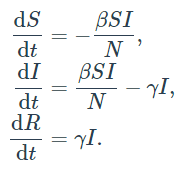

---

Fonte: https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/




# Previsões

O quarto e ultimo macro objetivo proposto é:

**"Baseado no cenário atual que temos no país, faça uma previsão da evolução da pandemia nos próximos 30
dias. E para os próximos 6 meses? O que você pode dizer sobre a acurácia dessas previsões?"**

Para realizar esta tarefa o modelo SIR (citado anteriormente) será implementado.

O motivo da escolha deste modelo e pontos de fragilidade, estarão comentados durante o processo de construção abaixo.



## Modelagem da base de dados

Para conseguir utilizar o modelo em questão, se faz necessário extrair S(t), I(t) e R(t) da base de dados utilizada para este estudo.

Vale ressaltar que  período que uma pessoa é considera uma potencial transmissora, foi de 14 dias.

Estes valores irão seguir a seguinte relação:

- `S(t) = (população do brasil) - I(t) - R(t)`
- `I(t) = soma da quantidade de casos novos casos positivos numa janela de 14 dias `
- `R(t) = (quantidade  de casos positivos acumulados) - I(t) - (quantidade de óbitos acumulados)`

Neste ponto é possível notar algumas simplificação que o modelo possui.

A primeira está presente na quantidade de pessoas que estão sucetíveis a serem contaminadas (S(t)),pois, não está sendo levado em conta que existem pessoas que são imunes ao vírus. Desta forma, o número previsto de óbitos será impactado por está simplificação.

A segunda simplificação está na quantidade de pessoas imunes ao vírus (R(t)), pois, existem casos no Brasil em que uma pessoa sentiu os efeitos da doença após ser contaminada uma segunda vez.


---
Como é possível notar, existem poucas amostras (apenas 310 dias), e essa foi a principal causa para a utilização desse modelo, em vista que modelos de machine learning complexos necessitam de uma quantidade muito maior de dados para fazer previsões precisas, para diversos pontos futuros (30 dias, 6 meses).

In [ ]:
df_br = df[df['country_alpha_3_code'] == 'BRA'].sort_values(by = 'report_date')[['report_date','people_positive_cases_count','people_death_count','population_count','people_positive_new_cases_count']].reset_index(drop = True)
total_mortos = df_br['people_death_count'].values[-1]
df_br.head()

,report_date,people_positive_cases_count,people_death_count,population_count,people_positive_new_cases_count
0,2019-12-31,0.0,0.0,212559409.0,0
1,2020-01-01,0.0,0.0,212559409.0,0
2,2020-01-02,0.0,0.0,212559409.0,0
3,2020-01-03,0.0,0.0,212559409.0,0
4,2020-01-04,0.0,0.0,212559409.0,0


In [ ]:
df_br['It'] =  df_br['people_positive_new_cases_count'].rolling(14).sum()
df_br['Rt'] = df_br['people_positive_cases_count'] - df_br['It'] - df_br['people_death_count']
df_br['St'] =  df_br['population_count'] - df_br['It'] - df_br['Rt']

df_br = df_br.drop(columns = ['report_date','people_positive_cases_count','people_death_count','population_count','people_positive_new_cases_count'])

df_br = df_br.fillna(0)

df_br.head()

,It,Rt,St
0,0.0,0.0,0.0
1,0.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,0.0,0.0,0.0


Um ponto muito importante é que os dados só serão considerados a partir do primeiro individuo infectado, antes disso o sistema está em inercia e o intuito aqui é modelar sua dinâmica

In [ ]:
df_br = df_br[df_br['It']>0].reset_index(drop = True)
df_br.head()

,It,Rt,St
0,1.0,0.0,212559408.0
1,1.0,0.0,212559408.0
2,1.0,0.0,212559408.0
3,1.0,0.0,212559408.0
4,2.0,0.0,212559407.0


In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(0,len(df_br['It']))), y=df_br['It'],
                    mode='lines+markers',
                    name='It'))

fig.add_trace(go.Scatter(x=list(range(0,len(df_br['Rt']))), y=df_br['Rt'],
                    mode='lines+markers',
                    name='Rt'))

fig.add_trace(go.Scatter(x=list(range(0,len(df_br['St']))), y=df_br['St'],
                    mode='lines+markers',
                    name='St'))

fig.update_layout(title='Qtd. Suscetíveis, Transmissores e Imunes',
                   xaxis_title='Dias',
                   yaxis_title='Quantidade')


fig.show()

## Modelo SIR

O modelo é definido com base nas equações diferenciais citadas anteriormente

### Equações Diferenciais

In [ ]:
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

### Simulações

Para a realização de previsões, basta:

- Integrar as equações dinâmicas
- Definir um valor para β 
- Definir um valor para γ
- Definir o período de simulação

In [ ]:
# População brasileira.
N = df_br['St'][0]+1

# Valores iniciais
I0 = df_br['It'][0]
R0 = df_br['Rt'][0]
S0 = N - I0 - R0 #todas as outras pessoas pode se contaminar, menos o paciente zero

#Taxa de contágio
beta = 0.2

#Recuperação, em media 14 dias
gamma = 1./14 

# tempo em dias
t = np.linspace(0, len(df_br['It']), len(df_br['It']))

# Vetor com as condições iniciais
y0 = S0, I0, R0

# Integrando as equações dinamicas para ter a resposta em relação ao tempo
ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(0,len(I))), y=I,
                    mode='lines+markers',
                    name='Ipred'))

fig.add_trace(go.Scatter(x=list(range(0,len(R))), y=R,
                    mode='lines+markers',
                    name='Rpred'))

fig.add_trace(go.Scatter(x=list(range(0,len(S))), y=S,
                    mode='lines+markers',
                    name='Spred'))


fig.update_layout(title='Qtd. Suscetíveis, Transmissores e Imunes (Previsão)',
                   xaxis_title='Dias',
                   yaxis_title='Quantidade')


fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(0,len(I))), y=I,
                    mode='lines+markers',
                    name='Ipred'))

fig.add_trace(go.Scatter(x=list(range(0,len(df_br['It']))), y=df_br['It'],
                    mode='lines+markers',
                    name='Ireal'))

fig.update_layout(title='Qtd. Transmissores (Previsto vs Real)',
                   xaxis_title='Dias',
                   yaxis_title='Quantidade')


fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(0,len(I))), y=R,
                    mode='lines+markers',
                    name='Rpred'))

fig.add_trace(go.Scatter(x=list(range(0,len(df_br['Rt']))), y=df_br['Rt'],
                    mode='lines+markers',
                    name='Rreal'))


fig.update_layout(title='Qtd. Imunes (Previsto vs Real)',
                   xaxis_title='Dias',
                   yaxis_title='Quantidade')


fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(0,len(I))), y=S,
                    mode='lines+markers',
                    name='Spred'))

fig.add_trace(go.Scatter(x=list(range(0,len(df_br['St']))), y=df_br['St'],
                    mode='lines+markers',
                    name='Sreal'))

fig.update_layout(title='Qtd. Suscetíveis (Previsto vs Real)',
                   xaxis_title='Dias',
                   yaxis_title='Quantidade')


fig.show()

#### 15 dias no futuro

Possível notar uma tendencia de redução no número de pessoas suscetiveis (S(t)) a doença, juntamente com um aumento no número de pessoas infectadas (I(t)) e imunes (R(t)).

In [ ]:
# População brasileira.
N = df_br['St'][0]+1 - total_mortos

# Valores iniciais
I0 = df_br['It'].values[-1]
R0 = df_br['Rt'].values[-1]
S0 = N - I0 - R0 #todas as outras pessoas pode se contaminar, menos o paciente zero

#Taxa de contágio
beta = 0.2

#Recuperação, em media 14 dias
gamma = 1./14 

# tempo em dias
t = np.linspace(0, 15, 15)

# Vetor com as condições iniciais
y0 = S0, I0, R0

# Integrando as equações dinamicas para ter a resposta em relação ao tempo
ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(0,len(I))), y=I,
                    mode='lines+markers',
                    name='Ipred'))

fig.add_trace(go.Scatter(x=list(range(0,len(R))), y=R,
                    mode='lines+markers',
                    name='Rpred'))

fig.add_trace(go.Scatter(x=list(range(0,len(S))), y=S,
                    mode='lines+markers',
                    name='Spred'))

fig.update_layout(title='Qtd. Suscetíveis, Transmissores e Imunes (15 dias no futuro)',
                   xaxis_title='Dias',
                   yaxis_title='Quantidade')


fig.show()

#### 6 Meses no futuro

É possível notar uma tendencia de estabilização nas curvas de pessoas suscetiveis (S(t)), infectadas (I(t)) e imunes (R(t)).

Vale ressaltar que a estabilização do número de pessoas infectadadas e sujeitas a doenla, estão muito longe de zero. 
Isto pode ser interpretado como margem para um novo surto da doença em meio a população. 

In [ ]:
# População brasileira.
N = df_br['St'][0]+1 - total_mortos

# Valores iniciais
I0 = df_br['It'].values[-1]
R0 = df_br['Rt'].values[-1]
S0 = N - I0 - R0 #todas as outras pessoas pode se contaminar, menos o paciente zero

#Taxa de contágio
beta = 0.2

#Recuperação, em media 14 dias
gamma = 1./14 

# tempo em dias
t = np.linspace(0, 180, 180)

# Vetor com as condições iniciais
y0 = S0, I0, R0

# Integrando as equações dinamicas para ter a resposta em relação ao tempo
ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(0,len(I))), y=I,
                    mode='lines+markers',
                    name='Ipred'))

fig.add_trace(go.Scatter(x=list(range(0,len(R))), y=R,
                    mode='lines+markers',
                    name='Rpred'))

fig.add_trace(go.Scatter(x=list(range(0,len(S))), y=S,
                    mode='lines+markers',
                    name='Spred'))

fig.update_layout(title='Qtd. Suscetíveis, Transmissores e Imunes (180 dias no futuro)',
                   xaxis_title='Dias',
                   yaxis_title='Quantidade')


fig.show()

### Conclusão

O modelo SIR é um modelo deterministico, isto implica que se todas as variáveis do sistema não estiverem modeladas corretatamente as previsões iram se distanciar muito dos valores reais, logo, os resultados mostrados anteriormente náo sáo completamente confiáveis.

Uma forma de melhorar minimamente o modelo, seria otimizar os parametros β e γ
através de uma função custo (Erro das predições de I(t) e R(t)), entretanto isso não iria surtir efeito ao ponto de tornar as previsões confiáveis, visto que diversas simplificações foram aplicadas na parte do equacionamento da dinâmica do sistema.


## Problema de Regressão

Como é impossível de modelar todas as não linearidades geradas pela COVID-19, o modelo SIR não é confiável.

Desta forma, vale a pena tentar prever os valores futuros de pessoas suscetíveis, infecciosas e imunes através de um problema de regressão.


### Separando os dados de treino e teste para prever 15 dias no futuro

In [ ]:
df_train = df_br.iloc[:-55,:]
df_test = df_br.iloc[-55:,:]

In [ ]:
print(df_train.shape)
print(df_test.shape)

(190, 3)
(55, 3)


## Montando regressor

Os dados precisão ser formatados para possibilitar um problema de regressão.
Com uma quantidade de features (X) e 15 targets, que irão representar 15 dias no futuro.

Serão 3 problemas de regressão ao todos, serão previstos os valores de R(t),S(t) e I(t)

In [ ]:
time_steps = 25
n_samples = df_train.shape[0] 
future_steps = 15


def regressor(df,time_steps,n_samples,future_steps):
  x = []
  y = []
  #It
  for i in range(time_steps,n_samples - future_steps): 
    x.append(df.iloc[i - time_steps : i, 0]) 
    y.append(df.iloc[i : i + future_steps, 0 ])

  x_it = np.reshape(np.array(x),(len(x),time_steps))
  y_it = np.array(y)


  x = []
  y = []

  #Rt
  for i in range(time_steps,n_samples - future_steps): 
    x.append(df.iloc[i - time_steps : i, 1]) 
    y.append(df.iloc[i : i + future_steps, 1 ])

  x_rt = np.reshape(np.array(x),(len(x),time_steps))
  y_rt = np.array(y)

  x = []
  y = []

  #St
  for i in range(time_steps,n_samples - future_steps): 
    x.append(df.iloc[i - time_steps : i, 2]) 
    y.append(df.iloc[i : i + future_steps, 2 ])

  x_st = np.reshape(np.array(x),(len(x),time_steps))
  y_st = np.array(y)

  return x_it,y_it,x_rt,y_rt,x_st,y_st


### Train
time_steps = 25
n_samples = df_train.shape[0] 
future_steps = 15
x_train_it,y_train_it,x_train_rt,y_train_rt,x_train_st,y_train_st = regressor(df_train,time_steps,n_samples,future_steps)

### Test
time_steps = 25
n_samples = df_test.shape[0] 
future_steps = 15
x_test_it,y_test_it,x_test_rt,y_test_rt,x_test_st,y_test_st = regressor(df_test,time_steps,n_samples,future_steps)

## Treinamento

Existem diversos algoritimos de regressão que poderiam ser utilizados para resolver este problema.

Testaremos os algoritmos descritos abaixo:

- Regressão Linear
- XGBoost


In [ ]:
'''
Este trabalho foi desenvolvido no google colab, logo, a versão do xgboost que vem  pré-instalada,
está desatualizada, irei instalar a mais recente.
'''

!pip install xgboost==1.2.1
import xgboost as xgb
from sklearn.linear_model import LinearRegression

### Regressão com Multiplos Outputs

Como o objetivo é prever 15 dias no futuro, o problema de regressão fica caracterizado como tendo multiplos valores a serem previstos.

Uma forma de realizar predições de diversos valores é criar um preditor para cada output desejado, logo, para 15 valores futuros irão ser criados 15 modelos de Regressão Linear, por exemplo.

Uma forma automática de realizar esta tarefa de criação de diversos modelos, é através da biblioteca `sklearn`, onde o modelo é passado como atributo e a biblioteca simpleste replica para a quantidade de outputs existentes no target estabelecido.

In [ ]:
from sklearn.multioutput import MultiOutputRegressor

### Regressão Linear

#### Pessoas Infectadas (I(t))

In [ ]:
#instanciando o modelo
lr = LinearRegression()

#treinando com multiplos outputs
lr_it = MultiOutputRegressor(estimator = lr).fit(x_train_it,y_train_it)

#### Pessoas Suscetíveis (S(t))

In [ ]:
#instanciando o modelo
lr = LinearRegression()

#treinando com multiplos outputs
lr_st = MultiOutputRegressor(estimator = lr).fit(x_train_st,y_train_st)

#### Pessoas Imunes (R(t))

In [ ]:
#instanciando o modelo
lr = LinearRegression()

#treinando com multiplos outputs
lr_rt = MultiOutputRegressor(estimator = lr).fit(x_train_rt,y_train_rt)

### XGBoost

#### Pessoas Infectadas (I(t))

In [ ]:
param_dist = {'objective':'reg:squarederror', 
              'n_estimators':20, 
              'max_depth':4, 
              "num_parallel_tree":5}
model = xgb.XGBRegressor(**param_dist)

model_xgb_it = MultiOutputRegressor(estimator = model).fit(x_train_it,y_train_it)

#### Pessoas Suscetíveis (S(t))

In [ ]:
param_dist = {'objective':'reg:squarederror', 
              'n_estimators':20, 
              'max_depth':4, 
              "num_parallel_tree":5}
model = xgb.XGBRegressor(**param_dist)

model_xgb_st = MultiOutputRegressor(estimator = model).fit(x_train_st,y_train_st)

#### Pessoas Imunes (R(t))

In [ ]:
param_dist = {'objective':'reg:squarederror', 
              'n_estimators':20, 
              'max_depth':4, 
              "num_parallel_tree":5}
model = xgb.XGBRegressor(**param_dist)

model_xgb_rt = MultiOutputRegressor(estimator = model).fit(x_train_rt,y_train_rt)

## Testando

Utilizarei os dados de teste, previamente separados de maneira `não aleatória` para que o modelo possa ser avaliado.

Como métrica de avaliação o MSE (mean squared error).

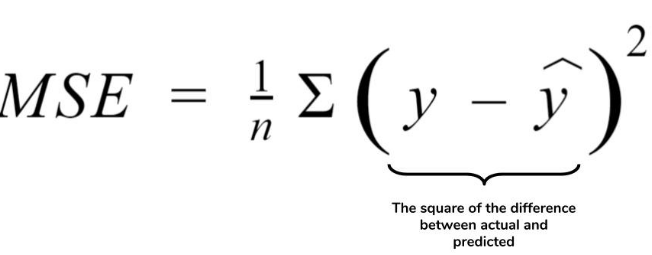

In [ ]:
from sklearn.metrics import mean_squared_error

### Regressão Linear

#### Pessoas Infectadas (I(t))

In [ ]:
ypred_it = lr_it.predict(x_test_it)
print(mean_squared_error(y_test_it,ypred_it))

2053791530.4317439


#### Pessoas Suscetíveis (S(t))

In [ ]:
ypred_st = lr_st.predict(x_test_st)
print(mean_squared_error(y_test_st,ypred_st))

33753555023.153328


#### Pessoas Imunes (R(t))

In [ ]:
ypred_rt = lr_rt.predict(x_test_rt)
print(mean_squared_error(y_test_rt,ypred_rt))

22698332627.81348


### XGBoost

#### Pessoas Infectadas (I(t))

In [ ]:
ypred_it = model_xgb_it.predict(x_test_it)
print(mean_squared_error(y_test_it,ypred_it))

56021864553.99174


#### Pessoas Suscetíveis (S(t))

In [ ]:
ypred_st = model_xgb_st.predict(x_test_st)
print(mean_squared_error(y_test_st,ypred_st))

1810895974801.2756


#### Pessoas Imunes (R(t))

In [ ]:
ypred_rt = model_xgb_rt.predict(x_test_rt)
print(mean_squared_error(y_test_rt,ypred_rt))

2786875649809.661


### Prevendo

Para prever 15 dias no futuro, utilizaremos a regressão linear prever a quantidade de pessoas infectadas (I(t)) e imunes (R(t)), pois o algoritmo apresentou um erro menor do que o XGBoost.

Já para prever o número de pessoas suscetíveis (S(t)), o XGBoost será utilizado, pois o obteve uma métrica melhor. 

#### Pessoas Infectadas (I(t))

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(0,len(list(lr_it.predict(np.reshape(x_test_it[-1],(1,25)))[0])))), 
                         y=list(lr_it.predict(np.reshape(x_test_it[-1],(1,25)))[0]),
                    mode='lines+markers',
                    name='Ipred'))

fig.update_layout(title='Previsão da Qtd. Pessoas Infectadas (15 dias a frente)',
                   xaxis_title='Dias',
                   yaxis_title='Quantidade')


fig.show()

#### Pessoas Suscetíveis (S(t))

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(0,len(list(model_xgb_st.predict(np.reshape(x_test_st[-1],(1,25)))[0])))), 
                         y=list(model_xgb_st.predict(np.reshape(x_test_st[-1],(1,25)))[0]),
                    mode='lines+markers',
                    name='Ipred'))

fig.update_layout(title='Previsão da Qtd. Pessoas Suscetíveis (15 dias a frente)',
                   xaxis_title='Dias',
                   yaxis_title='Quantidade')


fig.show()

#### Pessoas Imunes (R(t))

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(0,len(list(lr_rt.predict(np.reshape(x_test_rt[-1],(1,25)))[0])))), 
                         y=list(lr_rt.predict(np.reshape(x_test_rt[-1],(1,25)))[0]),
                    mode='lines+markers',
                    name='Ipred'))

fig.update_layout(title='Previsão da Qtd. Pessoas Imunes (15 dias a frente)',
                   xaxis_title='Dias',
                   yaxis_title='Quantidade')


fig.show()

### Prever 6 meses no futuro

Realizar a previsão de 6 meses no futuro com apenas 10 meses de dados disponíveis seria inviável, os resultados seriam extremamente Insatisfatórios com uma abordagem de regressão ou séries temporais.

Caso seja realmente nescessário prever 6 meses no futuro, seria muito mais prudente escolher o modelo SIR para realizar esta tarefa, pois a dinâmica desse tipo de sistema tende a ser padrão em longos períodos (indice de infectados e suscetíveis diminui enquanto o de imunes aumenta). 

### Prever 15 dias no futuro

Para esta necessidade, a abordagem com algoritmos de regressão é muito mais prudente, visto que a dinâmica do sistema tenta ser aprendida pelos modelos, diferentamente do modelo SIR, que tem uma resposta padrão, independentemente do período de tempo simulado.

# Considerações Finais

Para a resolução dos macro objetivos 1 e 2 diversos tipos de visualizações foram propostos, sempre com o intuito entender como está o Brasil em relação a pandemia e como se assemelha aos outros países, através de gráficos com o valor absoluto das quantidades de Infectados e Óbitos, de maneira acumulada e a evolução destes números ao longo do tempo (visões diárias e mensais).

Para os macros objetivos 3 e 4, era necessário uma abordagem com um viés de modelagem, tanto para formular o problema, quanto para realizar previsões. Para as previsões, foram utilizados dois tipos de modelos distintos (modelos probabilisticos e determinísticos) para resolver longos períodos de previsões futuras, vista a baixa volumetria de dados disponível.




# Referências

https://www.youtube.com/watch?v=ZWT1Gb_0kjc

https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/

https://www.youtube.com/watch?v=Qrp40ck3WpI

https://epidemicmodels.readthedocs.io/en/latest/